<a href="https://colab.research.google.com/github/srinivasiyengar/NewCastle-University-Internship/blob/main/Image_reconstruction_using_Dictionary_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                           Image Denoising using Dictionary Learning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from time import time
import cv2
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import cv2

#here any image can be used

In [30]:
image = cv2.imread('/barbara.png')

In [31]:
image.shape

(512, 512, 3)

In [32]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image.shape

(512, 512)

In [33]:
image = image / 255.

In [34]:
image = image[::4, ::4] + image[1::4, ::4] + image[::4, 1::4] + image[1::4, 1::4]
image /= 4.0
height, width = image.shape

In [35]:
print('Distorting image...')
distorted = image.copy()
distorted[:, width // 2:] += 0.075 * np.random.randn(height, width // 2)

Distorting image...


In [36]:
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

done in 0.01s.


In [37]:
print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

Learning the dictionary...
done in 7.50s.


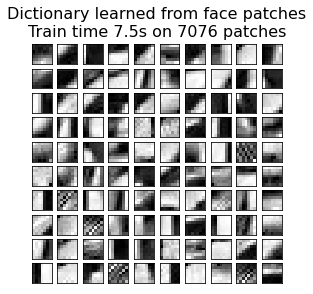

In [38]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

In [39]:
def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

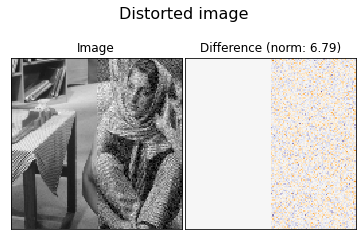

In [40]:
show_with_diff(distorted, image, 'Distorted image')

In [41]:
print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

Extracting noisy patches... 
done in 0.00s.


In [42]:
transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}),
    ('Least-angle regression\n5 atoms', 'lars',
     {'transform_n_nonzero_coefs': 5}),
    ('Thresholding\n alpha=0.1', 'threshold', {'transform_alpha': .1})]

Orthogonal Matching Pursuit
1 atom...
done in 0.51s.
Orthogonal Matching Pursuit
2 atoms...
done in 0.90s.
Least-angle regression
5 atoms...
done in 8.19s.
Thresholding
 alpha=0.1...
done in 0.08s.


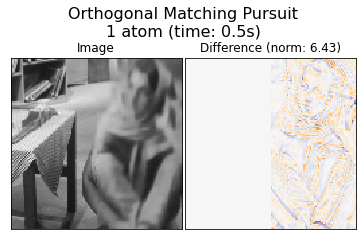

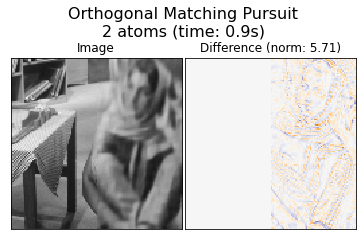

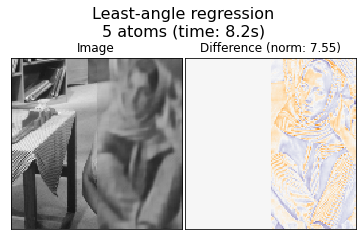

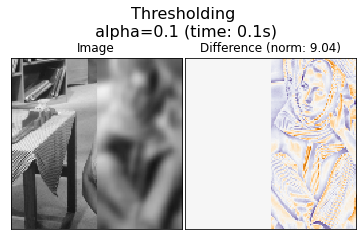

In [43]:
reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = image.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], image,
                   title + ' (time: %.1fs)' % dt)
plt.show()    